In [224]:
import numpy as np 
import pandas as pd 

In [225]:
students = pd.read_csv("student_5.csv")
exams = pd.read_csv("exams.csv")
enrolments = pd.read_csv("enrolements.csv")
rooms = pd.read_csv("rooms.csv")
slots= pd.read_csv("slots_45.csv")

In [226]:
class Exam:
    def __init__(self, exam_code, name, duration, department_code):
        self.code = exam_code
        self.name = name
        self.duration = duration
        self.duration_min = 0
        self.dep_code = department_code
        self.conflicts = 0
        self.exam_conflicts = set()
        self.priority = 0
        self.slot = -1
        self.student_codes = []
        self.students = []
        self.room = []
        self.room_assigned = False
        self.disability_requirement = False
        self.students_disabled = []
        self.students_assigned = 0

class Student:
    def __init__(self, student_code, course_code, disability):
        self.code = student_code
        self.course_code = course_code
        self.disability = disability
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code):
        self.student_code = student_code
        self.exam_code = exam_code

class Room:
    def __init__(self, room_code, capacity, disabled_suitability):
        self.code = room_code
        self.capacity = capacity
        self.status = False
        self.disabled_suitability = disabled_suitability
        self.seats_occupied = 0
class Slot:
    def __init__(self, index, date, day, type):
        self.index = index
        self.date = date
        self.day = day
        self.type = type
        self.exams = []
        self.student_count = 0
class RoomSlotMap:
    def __init__(self, slot, room, exams, capacity):
        self.slot = slot
        self.room = room
        self.capacity = capacity
        self.exams = exams

In [227]:
exam_objects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

student_objects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolment_objects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

room_objects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

slot_objects = [Slot(**kwargs) for kwargs in slots.to_dict(orient='records')]

In [228]:
for i in enrolment_objects:
    for j in student_objects:
        if j.code == i.student_code:
            j.exam_codes.append(i.exam_code)

In [229]:
for i in student_objects:
    for j in exam_objects:
        for k in i.exam_codes:
            if k == j.code:
                i.exams.append(j)

In [230]:
for i in enrolment_objects:
    for j in exam_objects:
        if j.code == i.exam_code:
            j.student_codes.append(i.student_code)

In [231]:
for i in exam_objects:
    for j in student_objects:
        for k in i.student_codes:
            if k == j.code:
                i.students.append(j)

In [232]:
for i in exam_objects:
    for j in i.students:
        if j.disability == True:
            i.disability_requirement = True
            i.students_disabled.append(j)

In [233]:
def getRoomKey(obj):
    return obj.capacity

In [234]:
roomSlotArr = []
for i in slot_objects:
    for j in sorted(room_objects, key=getRoomKey):
        roomSlotArr.append([i, j, [], j.capacity])

In [235]:
roomSlotArrDF = pd.DataFrame(roomSlotArr, columns = ["slot", "room", "exams", "capacity"])
roomSlotMapObjects = [RoomSlotMap(**kwargs) for kwargs in roomSlotArrDF.to_dict(orient='records')]

In [236]:
def hhToSeconds(s):
    t = 0
    splitTime = s.split(':')
    t = 60 * int(splitTime[0]) + int(splitTime[1])
    return t

In [237]:
for i in exam_objects:
    i.duration_min = hhToSeconds(str(i.duration))

In [238]:
def degreeOfConflict(exam):
    s = set()
    for i in exam.students:
        for j in i.exams:
            if exam.code != j.code:
                s.add(j)
    exam.exam_conflicts = s
    return len(s)

In [239]:
for i in exam_objects:
    i.conflicts = degreeOfConflict(i)

In [240]:
def partialExamOrdering():
    sup = np.zeros(len(exam_objects))
    for i in range(len(exam_objects)):
        for j in range(len(exam_objects)):
            if exam_objects[i].conflicts > exam_objects[j].conflicts:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].conflicts < exam_objects[j].conflicts:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students) > len(exam_objects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students) < len(exam_objects[j].students):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].duration_min > exam_objects[j].duration_min:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].duration_min < exam_objects[j].duration_min:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students_disabled) > len(exam_objects[j].students_disabled):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students_disabled) < len(exam_objects[j].students_disabled):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].code > exam_objects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif exam_objects[i].code < exam_objects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup                               

In [241]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(exam_objects)):
        exam_objects[i].priority = partialExamOrder[i]  

In [242]:
def getKey(obj):
    return obj.priority

In [243]:
pheromoneMatrix = []

def updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE):
    for i in range(len(exam_objects)):
        for j in range(len(slot_objects)):
            if exam_objects[i].slot.index == slot_objects[j].index:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j] + 1
            else:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j]
            if pheromoneMatrix[i][j] < t_min:
                pheromoneMatrix[i][j] = t_min
            elif pheromoneMatrix[i][j] > t_max:
                pheromoneMatrix[i][j] = t_max
    
def initPheromoneMatrix(exams, slots, value):
        for i in range(exams.size):
            pheromoneMatrix.append([value for j in range(len(slots))])
    

In [244]:
heuristicsMatrix = []

def initHeuristicsMatrix(exams, slots):
    for i in range(0, len(exams)):
        heuristicsMatrix.append([1 for j in range(len(slots))])

The room assignment is done on a daily
basis; firstly, all the timeslots for Monday are considered then the ones for Tuesday
until assignments are made for all timeslots of each day

1. All rooms are declared idle by setting ‗usage status‘ for each one to zero
2. For each timeslot on the day, do the following:
a) Select the next event yet to be assigned a room based on two criteria
b) (i) if suitable rooms (rooms with capacities that can hold the number of
students to participate in the event) exist for the event, assign the event
the room with the least capacity among the suitable rooms (ii) otherwise
try to move the event to another timeslot and restart the process, if no
64
feasible timeslot can be found for the event then stop the search and
declare the solution to be infeasible. (iii) Proceed to 2(c) if condition
b(i) is true.
c) Update the usage status of the room assigned to the event in b(i) by the
number of timeslots the event placed in it will occupy preventing it
from being assigned to another event while being busy.
d) If events remain in the timeslot not yet assigned a room then go back to
2(a).
3. Move to another day

In [245]:
def assignRooms(slots):
    for i in slot_objects:
        for j in roomSlotMapObjects:
                if i.room_assigned != True and i.slot == j.slot:
                    if len(i.students) < j.room.capacity and j.room.status == False:
                        i.room = j
                        i.room_assigned = True
                        j.room.status = True

In [246]:
def checkForHardConstraintViolations(exam, slot):
    score = 0
    for i in exam.exam_conflicts:
            if i.slot != -1:
                if i.slot.index == slot.index:
                    score += 4
                elif np.abs(i.slot.index - slot.index) < 2:
                    score += 4
    if slot.index == 12:
        score += 4
    if slot.index % 3 == 0 and exam.duration_min > 90:
        score += 4
    if len(exam.students) + slot.student_count > 2653:
        score += 4
    return score
                    

In [247]:
def numIncentive(exam, slot):
    score = 0
    if slot.index % 3 == 0 and exam.duration_min <= 90:
        score += 4
    return 0

In [248]:
def checkForSoftConstraintViolations(exam, slot):
    score = 0
    for i in exam.exam_conflicts:
        if i.slot != -1:
            if np.abs(i.slot.index - slot.index) < 3:
                score += 1
    return score

In [249]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(slot_objects[11])
    for i in exam.exam_conflicts:
        if i.slot != -1 and i.code != exam.code:
            forbiddenSlots.add(i.slot)
    return forbiddenSlots

In [250]:
def numAdditionalViolations(exam, slot):
    score = 0
    score += checkForHardConstraintViolations(exam, slot)
    score += checkForSoftConstraintViolations(exam, slot)
    return score

In [251]:
def pheroHeuristicSummation(examIndex, slotIndex):
    sum = 0
    for j in range(len(slot_objects)):
        if j != slotIndex:
            sum += (pheromoneMatrix[examIndex][j]**alpha) * (heuristicsMatrix[examIndex][j]**beta)
    return sum

In [252]:
forbiddenSlots = list(findForbiddenSlots(exam_objects[10]))
forbiddenSlots

In [253]:
def chooseSlot(examIndex, exam, slots, alpha, beta):
    desirability = np.zeros(len(slot_objects))
    forbiddenSlots = list(findForbiddenSlots(exam))
    for i in range(len(slot_objects)):
        for j in forbiddenSlots:
            if slot_objects[i].index == j.index:
                #print("Desirability for " + str(slot_objects[i].index) + " is -1")
                desirability[i] = -1
                continue
            heuristicsMatrix[examIndex][i] = 1 / ((1 + numIncentive(exam, slot_objects[i])) + numAdditionalViolations(exam, slot_objects[i]))
            desirability[i] = ((pheromoneMatrix[examIndex][i]**alpha) * (heuristicsMatrix[examIndex][i]**beta))/pheroHeuristicSummation(examIndex, i)
    #print(exam.code + ": " + ": " + str(slot_objects[np.argmax(desirability)].index))
    maxProb = np.argmax(desirability)
    #print(str(maxProb))
    desirableSlots = []
    for i in range(len(desirability)):
        if desirability[maxProb] == desirability[i]:
            desirableSlots.append(slot_objects[i])
    #print(str(desirableSlots))
    rand = np.random.randint(0, len(desirableSlots))
    return desirableSlots[rand]

In [254]:
examsChecked = set(exam_objects)
len(examsChecked)

800

In [255]:
def evaluateHardConstraints():
    countHard = 0
    examsChecked = []
    index = 0
    while index < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if k == j:
                    flag = True
            if flag:
                continue
            else:
                if exam.slot.index == j.slot.index:
                        countHard += 1
                elif np.abs(exam.slot.index - j.slot.index) < 2:
                    countHard += 1
        if exam.slot.index == 12:
            countHard += 1
        if exam.slot.index % 3 == 0 and exam.duration_min > 90:
            countHard += 1
        index += 1
        examsChecked.append(exam)
    return countHard

In [256]:
def evaluateSoftConstraints():
    countSoft = 0
    examsChecked = []
    index = 0
    while index  < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if  k == j:
                    flag = True
            if flag:
                continue
            else:
                if np.abs(exam.slot.index - j.slot.index) < 3:
                    countSoft += 1
        index += 1
        examsChecked.append(exam)
    return countSoft

In [257]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

1: move an event from a timeslot to another timeslot

2: swap the timeslots of two events


The second local search routine LS2(); which is derived from LS1() is applied only
after a feasible solution has been found, in fact it is applied to the iteration-best
solution Aib to remove events from tightly packed timeslots and place them in ‗idle‘
ones so as to make it easy to assign rooms to events in Aib. If any event exists that
cannot be assigned a room due to the fact that all suitable rooms of that event have
been assigned to other events in the same timeslot then it is moved to another timeslot
by LS2() and the room assignment is restarted. LS2() implements only the
neighbourhood move N1 in LS1() and its failure to find a new feasible timeslot for an
event which cannot be assigned a room in its current timeslot triggers the end of room
assignment and the solution is considered infeasible.


In [258]:
def findAnotherSlot(exam, conflictingExams, forbiddenSlot):
    slot = forbiddenSlot
    suitableSlots = set()
    for i in slot_objects:
        for j in conflictingExams:
            if i.index == j.slot.index:
                continue
            if np.abs(i.index - j.slot.index) < 2:
                continue
            if i.index == 12:
                continue
            if i.index % 3 == 0 and exam.duration_min > 90:
                continue
            if i.index != forbiddenSlot.index:
                suitableSlots.add(i)
    if len(suitableSlots) > 0:
        rand = np.random.randint(0, len(suitableSlots))
        slot = list(suitableSlots)[rand]
    else:
        rand = np.random.randint(0, len(conflictingExams))
        targetSlot = conflictingExams[rand].slot
        conflictingExams[rand].slot = exam.slot
        exam.slot = targetSlot
    return slot

In [259]:
def findAnotherSlotSoft(exam, conflictingExams, forbiddenSlot):
    slot = forbiddenSlot
    suitableSlots = set()
    for i in slot_objects:
        for j in conflictingExams:
            if i.index == j.slot.index:
                continue
            if np.abs(i.index - j.slot.index) < 2:
                continue
            if i.index == 12:
                continue
            if i.index % 3 == 0 and exam.duration_min > 90:
                continue
            if i.index != forbiddenSlot.index:
                suitableSlots.add(i)
    if len(suitableSlots) > 0:
        rand = np.random.randint(0, len(suitableSlots))
        slot = list(suitableSlots)[rand]
    return slot

In [260]:
def roomAssignment(exam, slot):
    flag = False
    for k in roomSlotMapObjects:
            if slot.index == k.slot.index and len(exam.students) < k.room.capacity:
                for l in exam_objects:
                    if l.room != -1:
                        if l.room != k.room:
                            exam.room = k.room
                            flag = False
                        else:
                            flag = True
    return flag

In [261]:
def getMapKey(obj):
    return obj.capacity

In [262]:
room_max_capacity = room_objects[0]
for i in room_objects:
    if room_max_capacity.capacity < i.capacity:
        room_max_capacity = i

In [263]:
def assignRoomsSequentially():
        sortedSlotRoomMapsDesc = sorted(roomSlotMapObjects, key=getMapKey, reverse=True)
        for i in slot_objects:
            slotExams = set(i.exams)
            print("🏠Assigning Rooms for DR for slot: " + str(i.index) + " with " + str(len(i.exams)) + "exams.")
            for n in list(slotExams):
                for o in roomSlotMapObjects:
                    if n.room_assigned == False and i == o.slot and o.room == room_max_capacity and len(n.students) > o.capacity:
                        print("🏠Assigning Multiple Rooms for exam: " + str(n.code) + " with " + str(len(n.students)) + "students. DR = " + str(n.disability_requirement))
                        students_assigned = 0
                        while students_assigned < len(n.students):
                                n.room.append(o)
                                o.room.seats_occupied += o.capacity - students_assigned
                                students_assigned += o.capacity - students_assigned
                        n.room_assigned = True
            for k in list(slotExams):
                if k.disability_requirement and k.room_assigned == False:
                    for j in roomSlotMapObjects:
                        if i == j.slot:
                            print("🏠Assigning Room for exam: " + str(k.code) + " with " + str(len(k.students)) + "students. DR = " + str(k.disability_requirement))
                            if j.room.disabled_suitability and np.abs(j.room.capacity - j.room.seats_occupied) > len(k.students):
                                print("🏠Room Assigned: " + str(j.room.code) + " with " + str(j.room.capacity) + "/" + str(j.room.seats_occupied))
                                k.room.append(j.room)
                                k.room_assigned = True
                                j.room.seats_occupied += len(k.students)
                            else:
                                print("🏠Room Already assigned or Not Assigned For: " + str(k.code) + " with " + str(len(k.students))+ "students. DR = " + str(k.disability_requirement))
            print("🏠Assigning Rooms for NON DR for slot: " + str(i.index) + " with " + str(len(i.exams)) + "exams.")
            for l in list(slotExams):
                if l.disability_requirement == False and l.room_assigned == False:
                    for m in roomSlotMapObjects:
                        if i == m.slot:
                            print("🏠Assigning Room for exam: " + str(l.code) + " with " + str(len(l.students)) + "students. DR = " + str(l.disability_requirement))
                            if np.abs(m.room.capacity - m.room.seats_occupied) > len(l.students):
                                print("🏠Room Assigned: " + str(m.room.code) + " with " + str(m.room.capacity) + "/" + str(m.room.seats_occupied))
                                l.room.append(m.room)
                                l.room_assigned = True
                                m.room.seats_occupied += len(k.students)
                            else:
                                print("🏠Room Already assigned or Not Assigned For: " + str(l.code) + " with " + str(len(l.students))+ "students. DR = " + str(l.disability_requirement))




In [264]:
def localSearchToEaseHardConstraints(solution):
    L = set()
    for i in range(len(solution)):
        exam = list(list(solution)[i])[0]
        slot = list(list(solution)[i])[1]
        flag = False
        print("Testing: " + exam.code + " currently at slot: " + str(slot.index) + " : " +slot.day + " : " + str(exam.duration_min))
        if exam.slot.index % 3 == 0 and exam.duration_min > 90:
            flag = True
        if exam.slot.index == 12:
            flag = True
        for j in exam.exam_conflicts:
            if j.slot.index == slot.index:
                print(exam.code + " conflicts with " + j.code + " at " + str(j.slot.index))
                flag = True
            if np.abs(j.slot.index - slot.index) < 2:
                print(exam.code + " conflicts with " + j.code + " at " + str(j.slot.index))
                flag = True
        if flag == True:
            print("Find another slot for: " + exam.code + " currently at slot: " + str(slot.index) + " : " +slot.day)
            slot = findAnotherSlot(exam, exam.exam_conflicts, slot)
            print("Found another slot for: " + exam.code + " at slot: " + str(slot.index) + " : " +slot.day)
            L.add((exam, slot))
        else:
            print("No slot needed for: " + exam.code + " at slot: " + str(slot.index) + " : " +slot.day)
            L.add((exam, slot))
        
    return L

In [265]:
def localSearchToEaseSoftConstraints(solution):
    L = set()
    for i in range(len(solution)):
        exam = list(list(solution)[i])[0]
        slot = list(list(solution)[i])[1]
        flag = False
        print("Testing: " + exam.code + " currently at slot: " + str(slot.index) + " : " +slot.day + " : " + str(exam.duration_min))
        for j in exam.exam_conflicts:
            if np.abs(j.slot.index - slot.index) < 3:
                print(exam.code + " soft conflicts with " + j.code + " at " + str(j.slot.index))
                flag = True
        if flag == True:
            print("Find another slot for: " + exam.code + " currently at slot: " + str(slot.index) + " : " +slot.day)
            slot = findAnotherSlotSoft(exam, exam.exam_conflicts, slot)
            L.add((exam, slot))
            print("Found another slot for: " + exam.code + " at slot: " + str(slot.index) + " : " +slot.day)
        else:
            print("No slot needed for: " + exam.code + " at slot: " + str(slot.index) + " : " +slot.day)
            L.add((exam, slot))
    return L

In [266]:
def assignSlotsForSolution(solution):
    for i in slot_objects:
        i.exams = []
    for i in solution:
        list(i)[0].slot = list(i)[1]
        list(i)[1].exams.append(list(i)[0])

In [267]:
EVAPORATION_RATE = 0.2
numAnts = 3
t_max = 5.0
t_min = 0.0019
MAX_ITER = 20
alpha = 1.0
beta = 4.0

In [268]:
index = 0
initPheromoneMatrix(exams, slot_objects, t_max)
initHeuristicsMatrix(exams, slot_objects)
totalConflictsForExams()
sortedExamsByPriority = sorted(exam_objects, key=getKey, reverse=True)
evaluationSoftMap = []
evaluationHardMap = []
A_gb = set()
prevScore = 0
while index < MAX_ITER:
    A_ib = set()
    prevScoreAnt = 0
    for k in range(numAnts):
        initHeuristicsMatrix(exams, slot_objects)
        A = set()
        chosenSlot = 0
        for i in range(len(exam_objects)):
            sortedExamsByPriority[i].slot = -1
        for i in slot_objects:
            i.student_count = 0
        for i in range(len(exam_objects)):
            chosenSlot = chooseSlot(i,sortedExamsByPriority[i], slot_objects, alpha, beta)
            sortedExamsByPriority[i].slot = chosenSlot
            chosenSlot.student_count += len(sortedExamsByPriority[i].students)
            A.add((sortedExamsByPriority[i], chosenSlot))
        assignSlotsForSolution(A)
        print("----LOCAL SEARCH TO EASE HARD CONSTRAINTS FOR ANT: " + str(k) + "------")
        Al = localSearchToEaseHardConstraints(A)
        assignSlotsForSolution(Al)
        scoreAl = evaluate()[0] + evaluate()[1]
        print("--Al with score: " + str(scoreAl))
        if A_ib != set():
            A_ib = Al if scoreAl < prevScoreAnt else A_ib
            prevScoreAnt = scoreAl if scoreAl < prevScoreAnt else prevScoreAnt
        else:
            A_ib = Al
            prevScoreAnt = scoreAl
        print("--A_ib with score: " + str(prevScoreAnt))
    assignSlotsForSolution(A_ib)
    print("------LOCAL SEARCH TO EASE SOFT CONSTRAINTS FOR ITERATION: " + str(index) + "--------")
    A_ibl = localSearchToEaseSoftConstraints(A_ib)
    assignSlotsForSolution(A_ibl)
    scoreA_ibl = evaluate()[0] + evaluate()[1]
    print("--A_ibl with score: " + str(scoreA_ibl))
    if A_gb != set():
        A_gb = A_ibl if scoreA_ibl < prevScore else A_gb
        prevScore = scoreA_ibl if scoreA_ibl < prevScore else prevScore
    else:
        A_gb = A_ibl
        prevScore = scoreA_ibl
    print("--A_gb with score: " + str(prevScore))
    assignSlotsForSolution(A_gb)
    updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE)
    evaluationSoftMap.append((index, evaluate()[0]))
    evaluationHardMap.append((index, evaluate()[1]))
    print("---|||Iteration :" + str(index) + " complete.|||---")
    index += 1
assignRoomsSequentially()

----LOCAL SEARCH TO EASE HARD CONSTRAINTS FOR ANT: 0------
Testing: M1B355E1 currently at slot: 7 : Friday : 120
No slot needed for: M1B355E1 at slot: 7 : Friday
Testing: H2CS06E1 currently at slot: 13 : Monday : 120
No slot needed for: H2CS06E1 at slot: 13 : Monday
Testing: C81HAAE1 currently at slot: 11 : Saturday : 60
No slot needed for: C81HAAE1 at slot: 11 : Saturday
Testing: H8B045E1 currently at slot: 17 : Tuesday : 120
No slot needed for: H8B045E1 at slot: 17 : Tuesday
Testing: G5P002E1 currently at slot: 1 : Wednesday : 120
No slot needed for: G5P002E1 at slot: 1 : Wednesday
Testing: C41101E1 currently at slot: 19 : Wednesday : 120
No slot needed for: C41101E1 at slot: 19 : Wednesday
Testing: J1C122E1 currently at slot: 32 : Monday : 120
No slot needed for: J1C122E1 at slot: 32 : Monday
Testing: N1B404E1 currently at slot: 22 : Thursday : 120
No slot needed for: N1B404E1 at slot: 22 : Thursday
Testing: L82120E1 currently at slot: 45 : Friday : 90
L82120E1 conflicts with R12001

KeyboardInterrupt: 

In [1]:
evalHardDF = pd.DataFrame(evaluationHardMap, columns=['Iterations', 'Violations'])
evalHardDF.plot.line(x='Iterations', y='Violations')

NameError: name 'pd' is not defined

<AxesSubplot:xlabel='Iterations'>

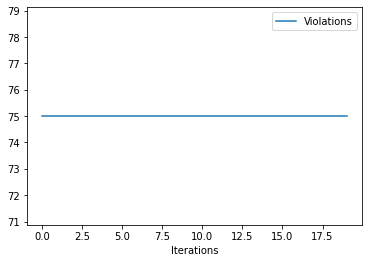

In [ ]:
evalSoftDF = pd.DataFrame(evaluationSoftMap, columns=['Iterations', 'Violations'])
evalSoftDF.plot.line(x='Iterations', y='Violations')

In [ ]:
studentArr = []
for i in student_objects:
    for j in i.exams:
        studentArr.append([i.code, j.code, j.slot.index, j.slot.day, j.slot.type, j.duration, len(j.students)])

In [ ]:
pd.DataFrame(studentArr).to_csv('student_output_1.csv')

In [ ]:
slotsUsed = set()
for i in slot_objects:
    examsAtslot = []
    print("Slot: " + str(i.index))
    for j in exam_objects:
        if i.index == j.slot.index:
            #print(j.code)
            examsAtslot.append([i.index, j.code, str(len(j.exam_conflicts))])
    print(len(examsAtslot))

Slot: 1
29
Slot: 2
26
Slot: 3
5
Slot: 4
26
Slot: 5
20
Slot: 6
7
Slot: 7
19
Slot: 8
29
Slot: 9
6
Slot: 10
27
Slot: 11
22
Slot: 12
0
Slot: 13
23
Slot: 14
22
Slot: 15
5
Slot: 16
18
Slot: 17
18
Slot: 18
5
Slot: 19
29
Slot: 20
26
Slot: 21
10
Slot: 22
23
Slot: 23
21
Slot: 24
5
Slot: 25
26
Slot: 26
26
Slot: 27
10
Slot: 28
27
Slot: 29
28
Slot: 30
6
Slot: 31
37
Slot: 32
26
Slot: 33
5
Slot: 34
28
Slot: 35
15
Slot: 36
8
Slot: 37
16
Slot: 38
15
Slot: 39
7
Slot: 40
25
Slot: 41
25
Slot: 42
13
Slot: 42
13
Slot: 44
24
Slot: 45
12


In [ ]:
for i in slot_objects:
    print(str(len(i.exams)))

29
26
5
26
20
7
19
29
6
27
22
0
23
22
5
18
18
5
29
26
10
23
21
5
26
26
10
27
28
6
37
26
5
28
15
8
16
15
7
25
25
4
9
24
12


In [ ]:
longExams = []
shortExams = []
for i in exam_objects:
    if i.duration_min > 90:
        longExams.append(i)
    else:
        shortExams.append(i)

In [ ]:
len(longExams), len(shortExams)

(479, 321)

In [ ]:
for i in exam_objects:
    print(str(i.room))